In [1]:
%cd /home/mrearle/repos/R2R-EnvDrop-ObjAttn/

/mnt-homes/kraken/mrearle/repos/R2R-EnvDrop-ObjAttn


# Arguments

In [2]:
import sys
import torch

metadata_parser_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/metadata_parser'
if metadata_parser_path not in sys.path:
    sys.path.append(metadata_parser_path)

mattersim_path = '/home/mrearle/datasets/Matterport3DSimulator/build'
if mattersim_path not in sys.path:
    sys.path.append(mattersim_path)
    
src_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src'
if src_path not in sys.path:
    sys.path.append(src_path)

sys.path

['/home/mrearle/venvs/r2r/lib/python36.zip',
 '/home/mrearle/venvs/r2r/lib/python3.6',
 '/home/mrearle/venvs/r2r/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/mrearle/venvs/r2r/lib/python3.6/site-packages',
 '/home/mrearle/venvs/r2r/lib/python3.6/site-packages/IPython/extensions',
 '/mnt-homes/kraken/mrearle/.ipython',
 '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/metadata_parser',
 '/home/mrearle/datasets/Matterport3DSimulator/build',
 '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src']

In [3]:
from parse_house_segmentations import HouseSegmentationFile

In [4]:
import os

class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

defaults = {
    'iters': 100000, 
    'name': 'default', 
    'train': 'speaker', 
    'maxInput': 80, 
    'maxDecode': 120, 
    'maxAction': 20, 
    'batchSize': 64, 
    'ignoreid': -100, 
    'feature_size': 2048, 
    'loadOptim': False, 
    'speaker': None, 
    'listener': None, 
    'load': None, 
    'aug': None, 
    'zero_init': False, 
    'ml_weight': 0.05, 
    'teacher_weight': 1.0, 
    'accumulate_grad': False, 
    'features': 'imagenet', 
    'featdropout': 0.3, 
    'self_train': False, 
    'candidates': 1, 
    'param_search': False, 
    'submit': False, 
    'beam': False, 
    'alpha': 0.5, 
    'optim': 'rms', 
    'lr': 0.0001, 
    'weight_decay': 0.0, 
    'dropout': 0.5, 
    'feedback': 'sample', 
    'teacher': 'final', 
    'epsilon': 0.1, 
    'rnn_dim': 512, 
    'wemb': 256, 
    'aemb': 64, 
    'proj': 512, 
    'fast_train': False, 
    'valid': False, 
    'candidate_mask': False,
    'bidir': True, 
    'encode': 'word', 
    'sub_out': 'tanh', 
    'attn': 'soft', 
    'angle_feat_size': 4, 
    'gamma': 0.9, 
    'normalize_loss': 'total', 
    'optimizer': 'rms', 
    'TRAIN_VOCAB': 'tasks/R2R/data/train_vocab.txt', 
    'TRAINVAL_VOCAB': 'tasks/R2R/data/trainval_vocab.txt', 
    'IMAGENET_FEATURES': 'img_features/ResNet-152-imagenet.tsv', 
    'CANDIDATE_FEATURES': 'img_features/ResNet-152-candidate.tsv', 
    'features_fast': 'img_features/ResNet-152-imagenet-fast.tsv', 
    'log_dir': 'snap/default'
}
args = Args(**defaults)
args.name = 'agent_bt_val'
args.attn = 'soft'
args.train = 'validlistener'
args.speaker = 'snap/speaker/state_dict/best_val_unseen_bleu'
args.load = 'snap/agent_obj_pruned/state_dict/best_val_unseen'
args.angle_feat_size = 128
args.accumulateGrad = True
args.featdropout = 0.4
args.subout = 'max'
args.optim = 'rms'
args.lr = 1e-4
args.iters = 10
args.maxAction = 35

args.TRAIN_VOCAB = "tasks/R2R/data/train_vocab.txt"
args.TRAINVAL_VOCAB = "tasks/R2R/data/trainval_vocab.txt"

args.IMAGENET_FEATURES = "img_features/ResNet-152-imagenet.tsv"
args.CANDIDATE_FEATURES = "img_features/ResNet-152-candidate.tsv"


args.OBJECT_FEATURES = "/home/mrearle/storage/img_features/ResNet-152-imagenet-conv.hdf5"
args.OBJECT_PROPOSALS = "/home/mrearle/storage/img_features/objProposals.json"

args.features_fast = "img_features/ResNet-152-imagenet-fast.tsv"
args.log_dir = "snap/%s" % args.name

if args.optim == "rms":
    print("Optimizer: Using RMSProp", flush=True)
    args.optimizer = torch.optim.RMSprop
elif args.optim == "adam":
    print("Optimizer: Using Adam", flush=True)
    args.optimizer = torch.optim.Adam
elif args.optim == "sgd":
    print("Optimizer: sgd", flush=True)
    args.optimizer = torch.optim.SGD
else:
    assert False

if not os.path.exists(args.log_dir):
    os.makedirs(args.log_dir)
DEBUG_FILE = open(os.path.join("snap", args.name, "debug.log"), "w")

Optimizer: Using RMSProp


In [5]:
import param
param.args = args

# Validation Code

## Imports

In [6]:
from agent import Seq2SeqAgent
from collections import defaultdict
import json
import numpy as np
log_dir = args.log_dir

In [7]:
from train import setup, read_vocab, Tokenizer, TRAIN_VOCAB, read_img_features, features, R2RBatch, Evaluation

## Environment

In [8]:
setup()
# Create a batch training environment that will also preprocess text
vocab = read_vocab(TRAIN_VOCAB)
tok = Tokenizer(vocab=vocab, encoding_length=args.maxInput)

feat_dict = read_img_features(features)

featurized_scans = set([key.split("_")[0] for key in list(feat_dict.keys())])

train_env = R2RBatch(
    feat_dict, batch_size=args.batchSize, splits=["train"], tokenizer=tok
)
from collections import OrderedDict

val_env_names = ["val_unseen"]

val_envs = OrderedDict(
        (
            (
                split,
                (
                    R2RBatch(
                        feat_dict,
                        batch_size=args.batchSize,
                        splits=[split],
                        tokenizer=tok,
                    ),
                    Evaluation([split], featurized_scans, tok),
                ),
            )
            for split in val_env_names
        )
    )

W2I is defaultdict True
OLD_VOCAB_SIZE 991
VOCAB_SIZE 992
VOACB 991
Start loading the image feature
Finish Loading the image feature from img_features/ResNet-152-imagenet.tsv in 45.9166 seconds
The feature size is 2048
Loading navigation graphs for 61 scans
R2RBatch loaded with 14039 instructions, using splits: train
The feature size is 2048
Loading navigation graphs for 11 scans
R2RBatch loaded with 2349 instructions, using splits: val_unseen


In [9]:
val_envs

OrderedDict([('val_unseen',
              (<env.R2RBatch at 0x7fd9f3bc2ac8>,
               <eval.Evaluation at 0x7fd9e4245208>))])

## Attach hook and run model

In [10]:
object_attentions = []
def obj_attention_hook(model, input, output):
    if model.traj_info is None:
        return None

    _, attentions = output
    traj_info = model.traj_info
    attns = attentions.detach()
    object_attentions.append((traj_info, attns))
    model.traj_info = None
    
viewpoint_attentions = []
def view_attention_hook(model, input, output):
    _, _, attn, _ = output
    viewpoint_attentions.append(attn)
        

In [13]:

agent = Seq2SeqAgent(train_env, "", tok, args.maxAction)

agent.decoder.connectionwise_obj_attn.register_forward_hook(obj_attention_hook)
agent.decoder.register_forward_hook(view_attention_hook)

args.load = 'snap/agent_obj_visual_mask/state_dict/best_val_unseen'
print(
    "Loaded the listener model at iter %d from %s"
    % (agent.load(args.load), args.load),
    flush=True,
)

Using Bidir in EncoderLSTM
Listener: Done Instantiating Model. Initializing Optimizers
Listener: Done Instantiating Optimizers. Initializing Loss
Listener: Done Instantiating Loss. Initializing Logs
Listener: Flushed
Listener: Done Instantiating Logs. Listener Initialized
Loaded the listener model at iter 32900 from snap/agent_obj_visual_mask/state_dict/best_val_unseen


In [14]:
for env_name, (env, evaluator) in val_envs.items():
    agent.logs = defaultdict(list)
    agent.env = env

    iters = None
    agent.test(use_dropout=False, feedback="argmax", iters=1)
    result = agent.get_results()

    break

## Parse Data

In [15]:
import importlib
from visualization import utils as _utils, instructions as _instructions
importlib.reload(_utils)
importlib.reload(_instructions)

get_result_iterator = _utils.get_result_iterator
get_instruction_function = _instructions.get_instruction_function

In [16]:
get_instruction = get_instruction_function()

In [17]:
result_iterator = enumerate(get_result_iterator(object_attentions, viewpoint_attentions, tok))

In [18]:
def get_next(result_iterator):
    for result_i, (info, attn, viewpoint_attn, candidates) in result_iterator:
        instruction = get_instruction(info['instr_id'])
        obj_names = [info['objects']['names'][int(i)] for i in info['obj_sample']]
        num_obj = sum(info['mask']).cpu().numpy()
        obj_names = obj_names[:num_obj]
        attn = attn[:, :num_obj]
        viewpoint_indices = candidates + ['STOP']

        trajectory = []
        prev = None
        for traj, _, _ in result[result_i]['trajectory']:
            if traj != prev:
                trajectory.append(traj)
            prev = traj

        yield info, attn, viewpoint_attn, candidates, obj_names, num_obj, viewpoint_indices, trajectory, instruction

In [19]:
parsed_res_iterator = get_next(result_iterator)

## Plot Functions

In [20]:
import matplotlib.pyplot as plt
import importlib
from visualization import visualization
importlib.reload(visualization)

get_objects = visualization.get_objects
visualize_panorama_img = visualization.visualize_panorama_img

In [21]:
%matplotlib inline

In [32]:
def make_plots(scan, viewpoint):
    objects, reachable_viewpoints = get_objects(scan, viewpoint)
    
    print('Current location:', scan, viewpoint)

    plt.close('all')
    viewpoint_heading = info['heading']

    images = []
    for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
        im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
        images.append(im)

    img = np.concatenate(images[::-1], axis=0)

    plt.figure(figsize=(18, 9))  
    plt.imshow(img)
    plt.xticks(np.linspace(0, img.shape[1] - 1, 5), [-180, -90, 0, 90, 180])
    plt.xlabel(f'relative heading from the agent')
    plt.yticks(np.linspace(0, img.shape[0] - 1, 5), [-180, -90, 0, 90, 180])

    bbox_style = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)

    x0, y0 = info['heading'], info['elevation']
    for obj in objects.itertuples():
        heading, elevation = float(obj.heading), float(obj.elevation)
        category = obj.category_mapping_name

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * img.shape[1]
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * img.shape[0]

        plt.plot(first_coord, second_coord, color='red', marker='v', linewidth=3)
        plt.annotate(category, (first_coord, second_coord), bbox=bbox_style)
        
        
    for i, reachable_viewpoint in enumerate(reachable_viewpoints.itertuples()):
        heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * img.shape[1]
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * img.shape[0]
        
        color = 'green' if reachable_viewpoint.name in trajectory else 'blue'
        plt.plot(first_coord, second_coord, color=color, marker='o', 
                markersize= 50 / reachable_viewpoint.distance, linewidth=1)
        plt.annotate(i, (first_coord, second_coord), bbox=bbox_style)
        print(i, reachable_viewpoint.name, reachable_viewpoint.name in trajectory)

    print(instruction)

    plt.show()

    fig, ax = plt.subplots(1,1, figsize=(10,20))
    im = ax.imshow(attn.transpose(1,0).numpy())

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(viewpoint_indices)))
    ax.set_yticks(np.arange(len(obj_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(viewpoint_indices)
    ax.set_yticklabels(obj_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(viewpoint_indices)):
        for j in range(len(obj_names)):
            text = ax.text(i, j, f'{attn[i, j]:.3f}',
                        ha="center", va="center", color="w")

    ax.set_title("")

    plt.show()

    fig, ax = plt.subplots(1,1, figsize=(10,20))
    im = ax.imshow(viewpoint_attn.unsqueeze(0).numpy())

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(viewpoint_indices)))
    ax.set_yticks([])
    # ... and label them with the respective list entries
    ax.set_xticklabels(viewpoint_indices)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(viewpoint_indices)):
        text = ax.text(i, 0, f'{torch.softmax(viewpoint_attn, -1)[i]:.3f}',
                    ha="center", va="center", color="w")

    ax.set_title("")

    plt.show()

# Plot

In [35]:
info, attn, viewpoint_attn, candidates, obj_names, num_obj, viewpoint_indices, trajectory, instruction = next(parsed_res_iterator)

torch.Size([4, 20]) torch.Size([4])


Current location: 2azQ1b91cZZ 0ae9a10c4c974a6f94b251899e1c3322
0 f113a975447c4f9dbac6564c10ed67d1 True
1 09f31cb3d1584052bdec594a45ab0d0f False
2 e88e705a46f74c87aa5eb71cb7fe7eed False
Walk past the railings and over the square rug.  Keep following the railings and walk across the round rug that is in the 11 o'clock position from the end of the square rug.  Stop after passing over the round rug, just before some stairs going down. 


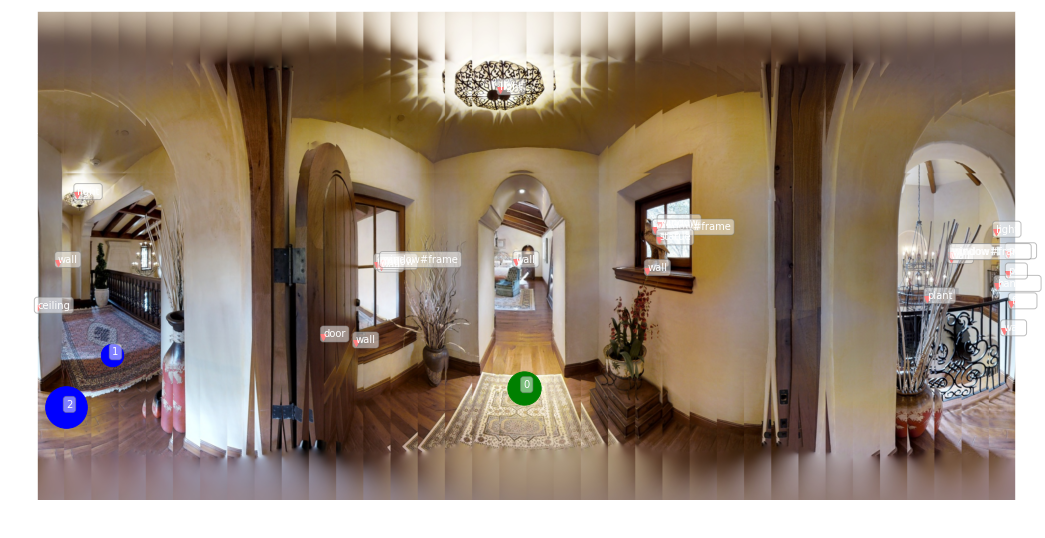

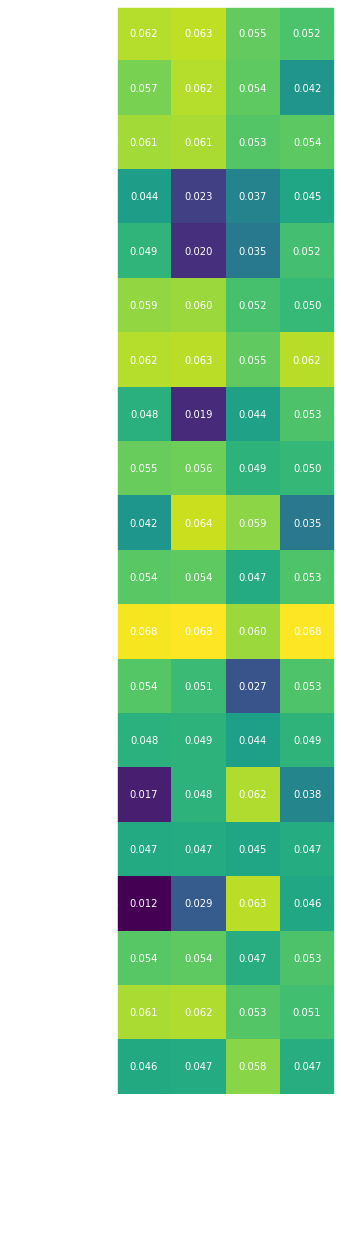

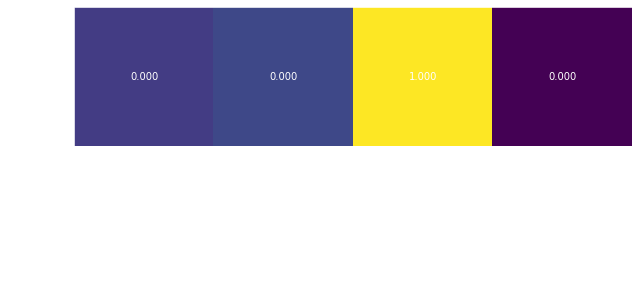

In [36]:
make_plots(info['scan'], info['viewpoint'])